In [57]:
!pip install scikit-optimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_predict
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.stats import randint,uniform
from hyperopt import fmin, tpe, hp, anneal, Trials
from hyperopt.pyll.base import scope
from sklearn import metrics
from functools import partial
import random
import skopt
from skopt import space
from skopt import gp_minimize
from sklearn.utils import resample, shuffle

RANDOM_STATE = 42
N_SPLITS = 10
kf = KFold(n_splits=N_SPLITS, random_state=RANDOM_STATE, shuffle=True)
skf = StratifiedKFold(n_splits=N_SPLITS, random_state=RANDOM_STATE, shuffle= True)
SCORING = "f1"
EVALS_IN_HYPEROPT = 3000
EVALS_IN_BAYESIAN = 500
EVALS_IN_RANDOM = 3000
FOLDS = skf
N_JOBS = -1

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [58]:
def print_params(classifier):
  print("Trenutni parametri modela:")
  for param, value in classifier.get_params().items():
    print(f"{param}: {value}")

In [59]:
def print_scores_with_cross_val(classifier, optimization_algo = ""):
  print(f'Točnost modela {optimization_algo} sa unakrsnom provjerom: {cross_val_score(classifier, X, y, cv=FOLDS, scoring="accuracy", n_jobs=N_JOBS).mean() * 100}%')
  print(f'Standardna devijacija modela {optimization_algo} sa unakrnsom provjerom: {cross_val_score(classifier, X, y, cv=FOLDS, scoring="accuracy", n_jobs=N_JOBS).std() * 100} %')
  print(f'ROC AUC vrijednost modela {optimization_algo} : {cross_val_score(classifier, X, y, cv=FOLDS, scoring="roc_auc", n_jobs=N_JOBS).mean() * 100} %')
  print(f'F1 vrijednost modela {optimization_algo} : {cross_val_score(classifier, X, y, cv=FOLDS, scoring="f1", n_jobs=N_JOBS).mean() * 100} %')

In [60]:
dataset = pd.read_csv('pima-indians-diabetes.csv')

In [61]:
dataset.describe()

,6,148,72,35,0,33.6,0.627,50,1
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,3.842243,120.859192,69.101695,20.517601,79.903520,31.990482,0.471674,33.219035,0.348110
std,3.370877,31.978468,19.368155,15.954059,115.283105,7.889091,0.331497,11.752296,0.476682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,32.000000,32.000000,0.371000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,127.500000,36.600000,0.625000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [62]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [63]:
print('Shape of X: ', X.shape)
print('Shape of Y: ', y.shape)

Shape of X:  (767, 8)
Shape of Y:  (767,)


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, shuffle=True)

In [65]:
lgbm_classic= LGBMClassifier(random_state=RANDOM_STATE)

In [66]:
lgbm_classic.fit(X_train, y_train)
y_pred = lgbm_classic.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"Točnost LGBM klasifikatora bez unakrsne provjere: {lgbm_classic.score(X_test, y_test) * 100} %")

[[78 19]
 [13 44]]
Točnost LGBM klasifikatora bez unakrsne provjere: 79.22077922077922 %


In [67]:
print_params(lgbm_classic)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.1
max_depth: -1
min_child_samples: 20
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 100
n_jobs: -1
num_leaves: 31
objective: None
random_state: 42
reg_alpha: 0.0
reg_lambda: 0.0
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


In [68]:
%%time
params_grid_search = {'learning_rate': [0.001, 0.01, 0.5],
          'num_leaves': [10, 20, 150, 300],
          'n_estimators': [500, 1500, 3000],
          'max_depth': [3, 8, 12],
          'min_child_samples': [5, 30, 150],
          'reg_lambda': [1, 50, 99],
          'reg_alpha' : [1, 50, 99]}
grid_search = GridSearchCV(estimator=LGBMClassifier(random_state=RANDOM_STATE),
                           param_grid=params_grid_search,
                           scoring=SCORING,
                           cv=FOLDS,
                           n_jobs=N_JOBS,
                           return_train_score=True,
                           verbose=10)
grid_search.fit(X, y)
print(f"Najbolja točnost sa Grid Search-om: {grid_search.best_score_ * 100} %")
print(f"Najbolji parametri sa Grid Search-om: {grid_search.best_params_}")

Fitting 10 folds for each of 2916 candidates, totalling 29160 fits
Najbolja točnost sa Grid Search-om: 65.22410911365317 %
Najbolji parametri sa Grid Search-om: {'learning_rate': 0.01, 'max_depth': 8, 'min_child_samples': 5, 'n_estimators': 1500, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 99}
CPU times: total: 33.5 s
Wall time: 12min 27s


In [69]:
lgbm_grid_search = LGBMClassifier(**grid_search.best_params_)
lgbm_grid_search.set_params(random_state = RANDOM_STATE )
print_params(lgbm_grid_search)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.01
max_depth: 8
min_child_samples: 5
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 1500
n_jobs: -1
num_leaves: 10
objective: None
random_state: 42
reg_alpha: 1
reg_lambda: 99
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

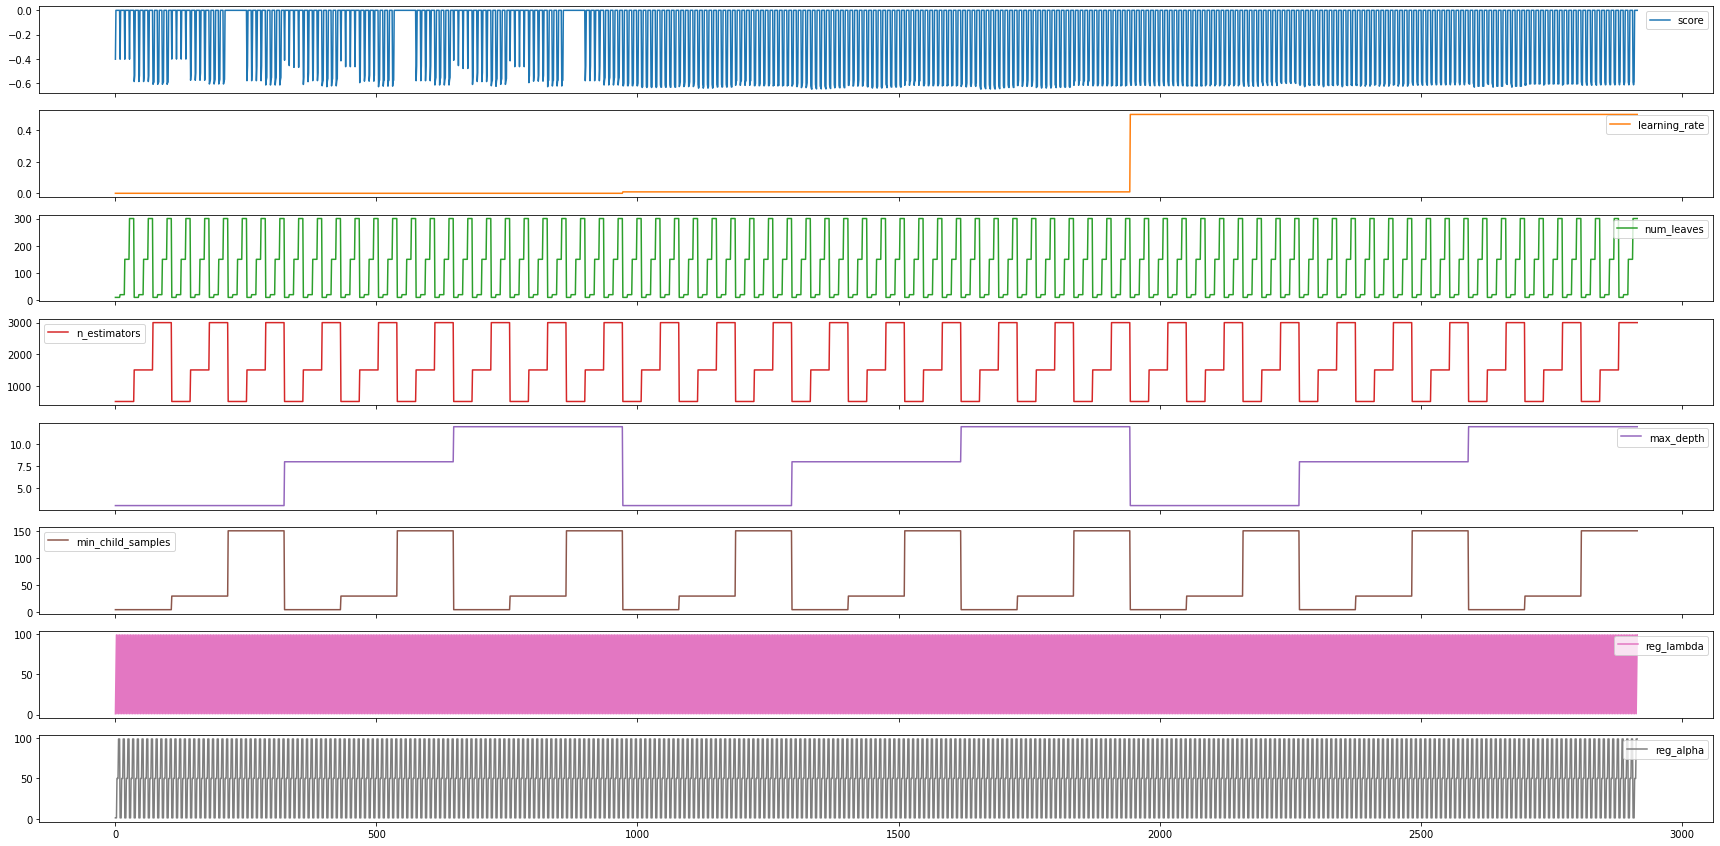

In [70]:
grid_search_scores = grid_search.cv_results_
grid_search_results_df=pd.DataFrame(np.transpose([-grid_search_scores['mean_test_score'],
                                         grid_search_scores['param_learning_rate'].data,
                                         grid_search_scores['param_num_leaves'].data,
                                         grid_search_scores['param_n_estimators'].data,
                                         grid_search_scores['param_max_depth'].data,
                                         grid_search_scores['param_min_child_samples'].data,
                                         grid_search_scores['param_reg_lambda'].data,
                                         grid_search_scores['param_reg_alpha'].data]),
                           columns=['score', 'learning_rate', 'num_leaves', 'n_estimators', 'max_depth', 'min_child_samples', 'reg_lambda', 'reg_alpha'])
grid_search_results_df.plot(subplots=True, figsize=(30, 15))

In [71]:
%%time
params_random_search = {'learning_rate' : uniform(0.01,0.99),
          'num_leaves': randint(20,3000),
          'n_estimators': randint(500,3000),
          'max_depth': randint(3,12),
          'min_child_samples': randint(2,300),
          'reg_lambda': uniform(0.01,99.99),
          'reg_alpha': uniform(0.01,99.99),
          }
random_search = RandomizedSearchCV(estimator = LGBMClassifier(random_state=RANDOM_STATE),
                                   param_distributions = params_random_search,
                                   n_iter = EVALS_IN_RANDOM,
                                   scoring = SCORING,
                                   cv = FOLDS,
                                   random_state = RANDOM_STATE,
                                   n_jobs = N_JOBS,
                                   verbose=10
                                   )
random_search.fit(X, y)
print("Najbolja točnost sa Random Search-om: {:.2f} %".format(random_search.best_score_*100))
print("Najbolji parametri prema Random Search-om:", random_search.best_params_)

Fitting 10 folds for each of 3000 candidates, totalling 30000 fits
Najbolja točnost sa Random Search-om: 65.35 %
Najbolji parametri prema Random Search-om: {'learning_rate': 0.8898590516456748, 'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 870, 'num_leaves': 1462, 'reg_alpha': 5.602075749321284, 'reg_lambda': 14.226715824971288}
CPU times: total: 28.6 s
Wall time: 5min 18s


In [72]:
lgbm_random_search = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_random_search.set_params(**random_search.best_params_)
print_params(lgbm_random_search)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.8898590516456748
max_depth: 10
min_child_samples: 10
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 870
n_jobs: -1
num_leaves: 1462
objective: None
random_state: 42
reg_alpha: 5.602075749321284
reg_lambda: 14.226715824971288
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

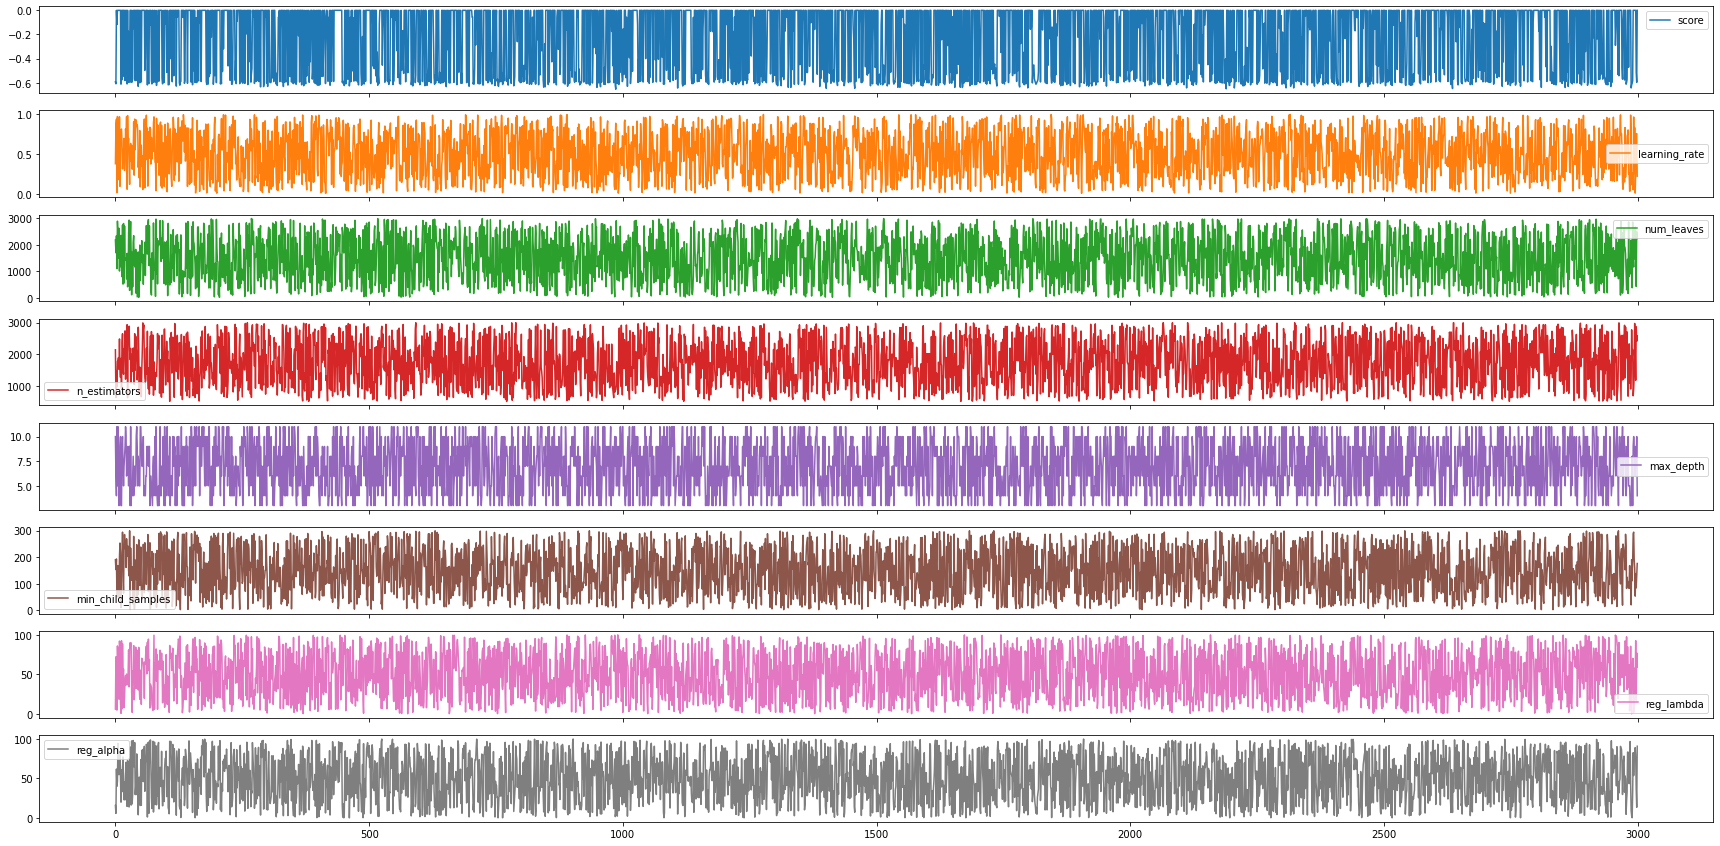

In [73]:
random_search_scores = random_search.cv_results_
random_search_results_df=pd.DataFrame(np.transpose([-random_search_scores['mean_test_score'],
                                         random_search_scores['param_learning_rate'].data,
                                         random_search_scores['param_num_leaves'].data,
                                         random_search_scores['param_n_estimators'].data,
                                         random_search_scores['param_max_depth'].data,
                                         random_search_scores['param_min_child_samples'].data,
                                         random_search_scores['param_reg_lambda'].data,
                                         random_search_scores['param_reg_alpha'].data]),
                           columns=['score', 'learning_rate', 'num_leaves', 'n_estimators', 'max_depth', 'min_child_samples', 'reg_lambda', 'reg_alpha'])
random_search_results_df.plot(subplots=True, figsize=(30, 15))

In [74]:
def optimize_hp(params, x, y ):
    model = LGBMClassifier(**params)
    return -1.0 * np.mean(cross_val_score(model, x, y, cv=FOLDS, scoring=SCORING, n_jobs=N_JOBS))

space_hyperopt = {
    'learning_rate' : hp.uniform('learning_rate', 0.001 ,1),
    'num_leaves' : scope.int(hp.quniform('num_leaves', 20,3000,1)),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 500,3000,1)),
    'max_depth' : scope.int(hp.quniform('max_depth', 3, 12,1)),
    'min_child_samples' : scope.int(hp.quniform('min_child_samples', 2, 300,1)),
    'reg_lambda' : hp.uniform('reg_lambda', 0.01 ,100),
    'reg_alpha' : hp.uniform('reg_alpha', 0.01 ,100),
}


optimization_function_hp = partial(optimize_hp, x= X, y = y)

In [75]:
%%time
trials_anneal = Trials()
result_anneal = fmin(fn=optimization_function_hp, space = space_hyperopt, algo = anneal.suggest, max_evals = EVALS_IN_HYPEROPT, trials = trials_anneal)
print(result_anneal)

100%|███████████████████████████████████████████| 3000/3000 [12:34<00:00,  3.98trial/s, best loss: -0.6531427484072164]
{'learning_rate': 0.35127324841339935, 'max_depth': 10.0, 'min_child_samples': 111.0, 'n_estimators': 2209.0, 'num_leaves': 1395.0, 'reg_alpha': 1.8914110321208635, 'reg_lambda': 51.7555052227802}
CPU times: total: 17.7 s
Wall time: 12min 34s


In [76]:
result_anneal["num_leaves"] = int(result_anneal["num_leaves"])
result_anneal["n_estimators"] = int(result_anneal["n_estimators"])
result_anneal["max_depth"] = int(result_anneal["max_depth"])
result_anneal["min_child_samples"] = int(result_anneal["min_child_samples"])
lgbm_anneal = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_anneal.set_params(**result_anneal)
print_params(lgbm_anneal)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.35127324841339935
max_depth: 10
min_child_samples: 111
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 2209
n_jobs: -1
num_leaves: 1395
objective: None
random_state: 42
reg_alpha: 1.8914110321208635
reg_lambda: 51.7555052227802
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

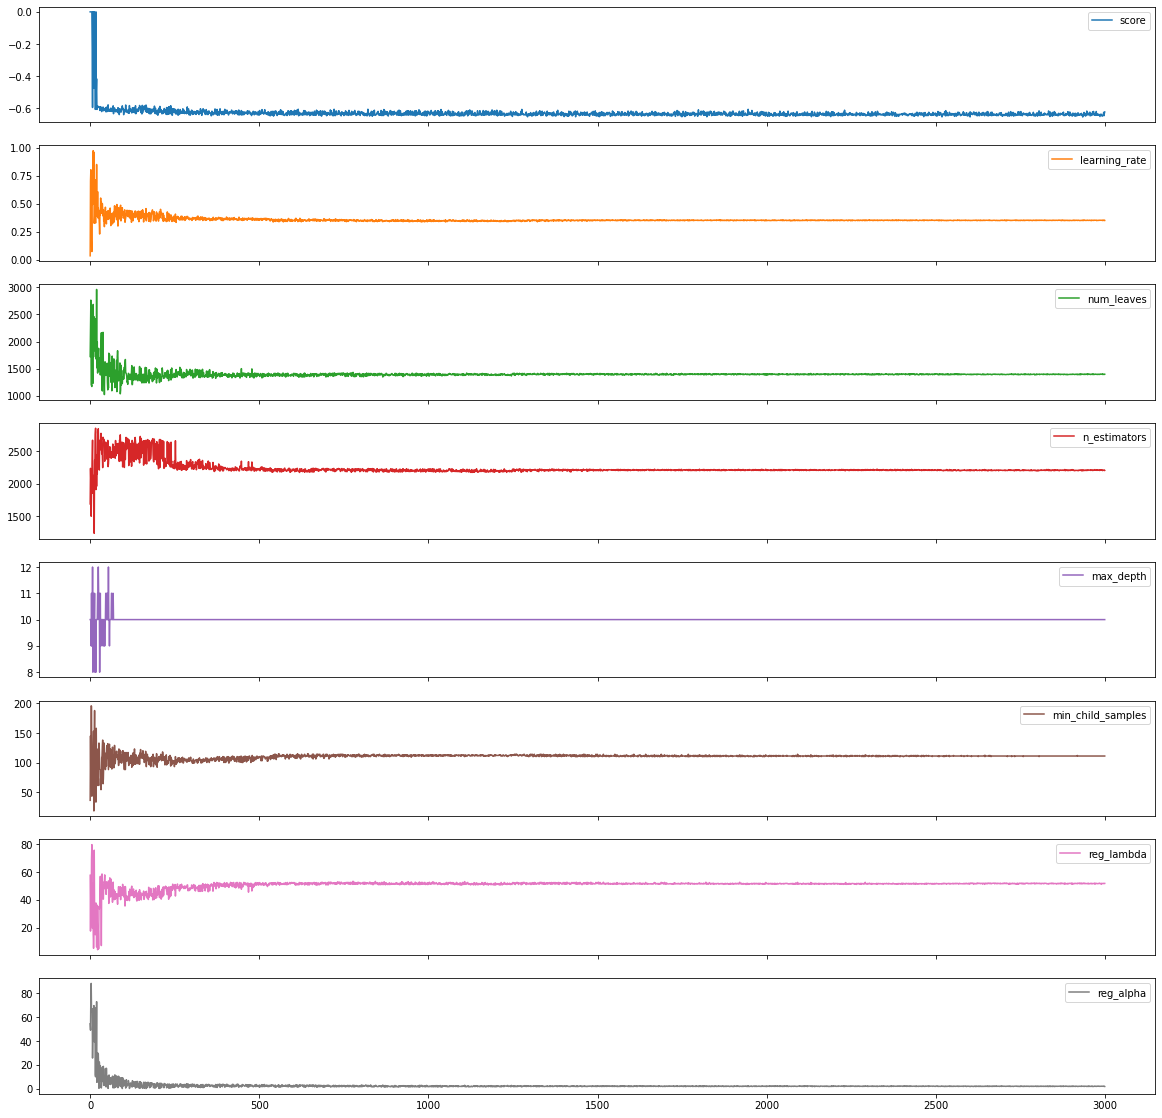

In [77]:
anneal_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['num_leaves'][0],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['min_child_samples'][0],
                      x['misc']['vals']['reg_lambda'][0],
                      x['misc']['vals']['reg_alpha'][0]] for x in trials_anneal.trials])

anneal_results_df=pd.DataFrame(anneal_results,
                           columns=['score', 'learning_rate', 'num_leaves', 'n_estimators', 'max_depth', 'min_child_samples', 'reg_lambda', 'reg_alpha'])
anneal_results_df.plot(subplots=True,figsize=(20, 20))

In [78]:
%%time
trials_tpe = Trials()
result_tpe = fmin(fn=optimization_function_hp, space = space_hyperopt, algo = tpe.suggest, max_evals = EVALS_IN_HYPEROPT, trials = trials_tpe)
print(result_tpe)

100%|███████████████████████████████████████████| 3000/3000 [19:53<00:00,  2.51trial/s, best loss: -0.6786142980133753]
{'learning_rate': 0.8529784441999736, 'max_depth': 7.0, 'min_child_samples': 2.0, 'n_estimators': 2128.0, 'num_leaves': 2281.0, 'reg_alpha': 5.036940577536111, 'reg_lambda': 17.50011765032669}
CPU times: total: 7min 56s
Wall time: 19min 53s


In [79]:
result_tpe["num_leaves"] = int(result_tpe["num_leaves"])
result_tpe["n_estimators"] = int(result_tpe["n_estimators"])
result_tpe["max_depth"] = int(result_tpe["max_depth"])
result_tpe["min_child_samples"] = int(result_tpe["min_child_samples"])
lgbm_tpe = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_tpe.set_params(**result_tpe)
print_params(lgbm_tpe)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.8529784441999736
max_depth: 7
min_child_samples: 2
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 2128
n_jobs: -1
num_leaves: 2281
objective: None
random_state: 42
reg_alpha: 5.036940577536111
reg_lambda: 17.50011765032669
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

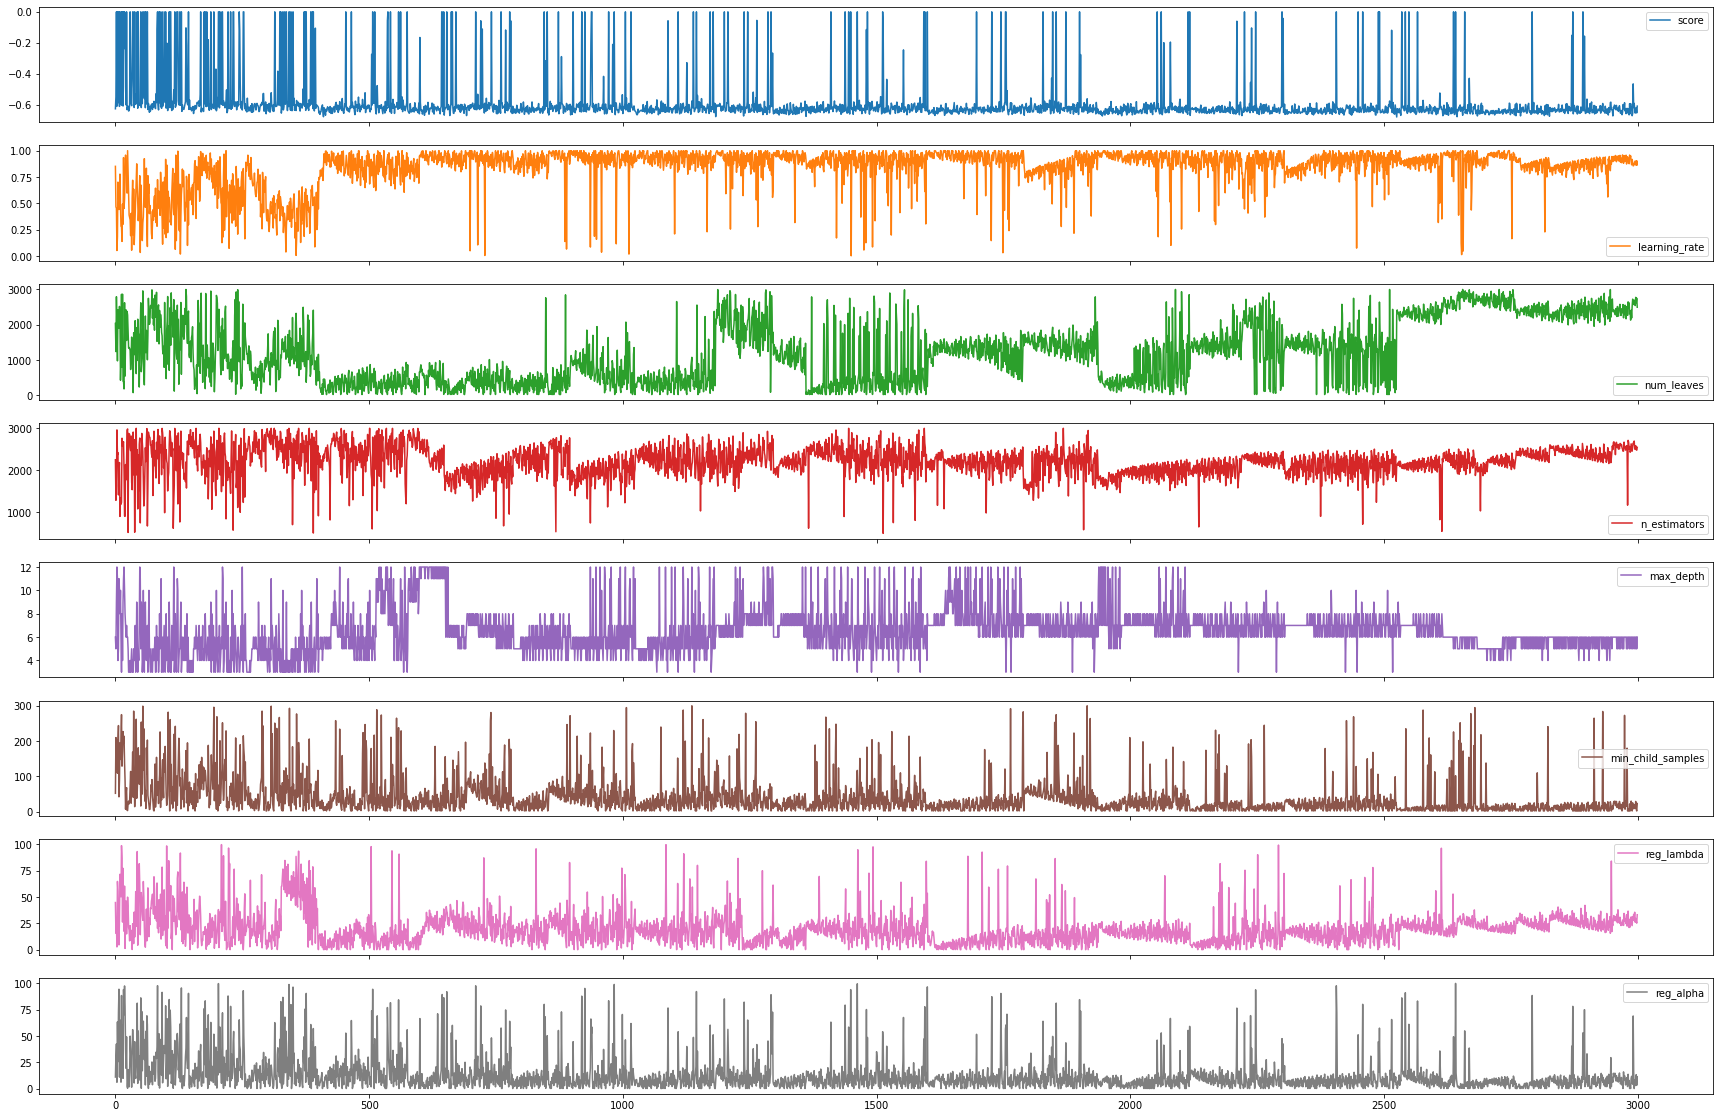

In [80]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['num_leaves'][0],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['min_child_samples'][0],
                      x['misc']['vals']['reg_lambda'][0],
                      x['misc']['vals']['reg_alpha'][0]] for x in trials_tpe.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'num_leaves', 'n_estimators', 'max_depth', 'min_child_samples', 'reg_lambda', 'reg_alpha'])
tpe_results_df.plot(subplots=True,figsize=(30, 20))

In [81]:
def optimize_bayesian(params, param_names ,x, y):
    params = dict(zip(param_names, params))
    model = LGBMClassifier(**params)
    return -1.0 * np.mean(cross_val_score(model, x, y, cv=FOLDS, scoring=SCORING, n_jobs=N_JOBS))

In [82]:
%%time
param_space = [
               space.Real(0.001,1, prior = "uniform", name = "learning_rate"),
               space.Integer(20,3000, name = "num_leaves"),
               space.Integer(500,3000, name = "n_estimators"),
               space.Integer(3,12, name = "max_depth"),
               space.Integer(2,300, name = "min_child_samples"),
               space.Real(0.01,100, prior = "uniform", name = "reg_lambda"),
               space.Real(0.01,100, prior = "uniform", name = "reg_alpha")
]

param_names=[
             "learning_rate",
             "num_leaves",
             "n_estimators",
             "max_depth",
             "min_child_samples",
             "reg_lambda",
             "reg_alpha",
]

optimization_function_bayesian = partial(optimize_bayesian, param_names = param_names, x = X, y= y)
result_bayesian = gp_minimize(optimization_function_bayesian, dimensions = param_space, n_calls = EVALS_IN_BAYESIAN, n_initial_points=10, verbose=10, n_jobs=N_JOBS)

bayesian_parameters = dict(zip(param_names, result_bayesian.x))
print(bayesian_parameters)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2009
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0839
Function value obtained: -0.0000
Current minimum: -0.0000
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1325
Function value obtained: -0.6156
Current minimum: -0.6156
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1299
Function value obtained: -0.0000
Current minimum: -0.6156
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0796
Function value obtained: -0.6040
Current minimum: -0.6156
Iteration No: 6 started. 

In [83]:
lgbm_bayesian = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_bayesian.set_params(**bayesian_parameters)
print_params(lgbm_bayesian)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 1.0
max_depth: 9
min_child_samples: 2
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 3000
n_jobs: -1
num_leaves: 3000
objective: None
random_state: 42
reg_alpha: 5.009244879497562
reg_lambda: 17.32012616551272
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

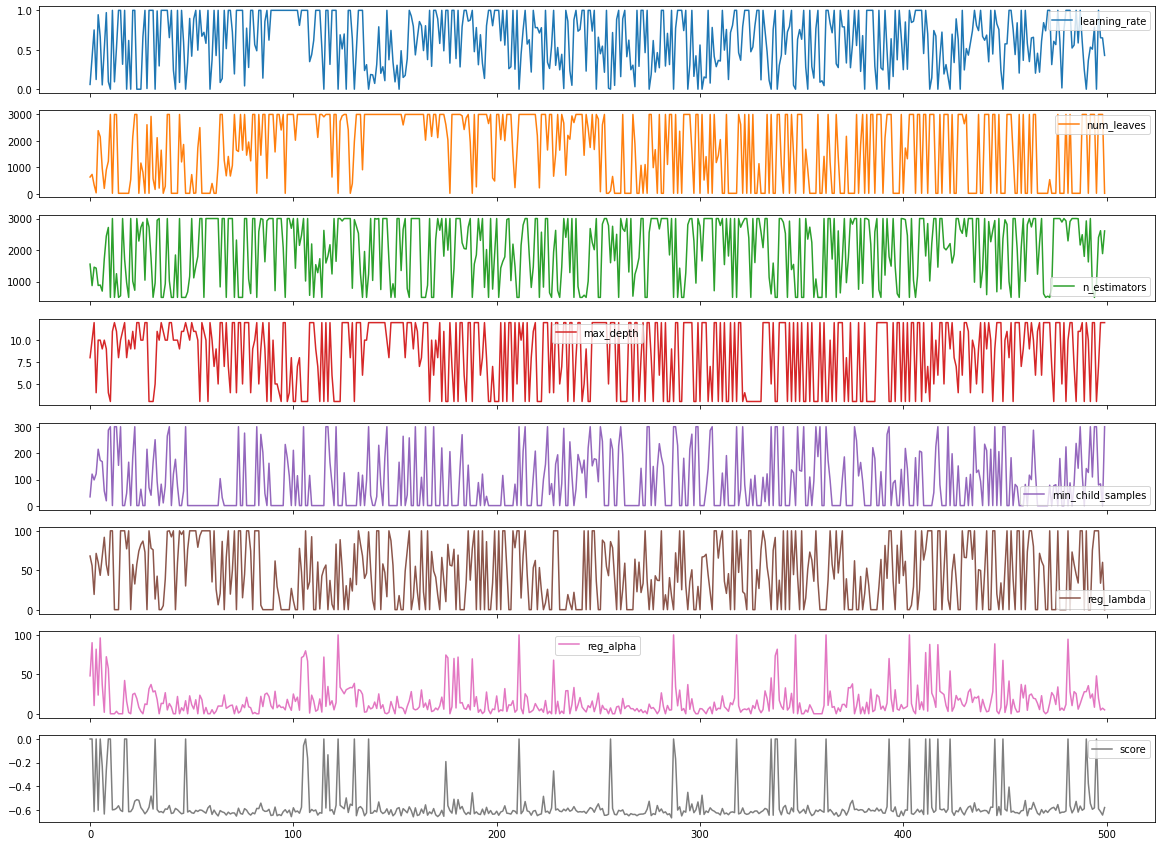

In [93]:
bayesian_results_df = pd.DataFrame(result_bayesian.x_iters)
list_of_scores = result_bayesian.func_vals.tolist()
bayesian_results_df['score'] = list_of_scores

bayesian_results_df.columns=('learning_rate','num_leaves','n_estimators','max_depth', "min_child_samples", "reg_lambda", "reg_alpha",'score')
bayesian_results_df.plot(subplots=True,figsize=(20, 15))

In [85]:
print_scores_with_cross_val(lgbm_classic, "bez optimizacije")
print("\n")
print_scores_with_cross_val(lgbm_grid_search, "s Grid Search-om")
print("\n")
print_scores_with_cross_val(lgbm_random_search, "s Random Searchom-om")
print("\n")
print_scores_with_cross_val(lgbm_anneal, "s Hyperopt-Anneal")
print("\n")
print_scores_with_cross_val(lgbm_tpe, "s Hyperopt-Tpe")
print("\n")
print_scores_with_cross_val(lgbm_bayesian, "s Bayesian")

Točnost modela bez optimizacije sa unakrsnom provjerom: 75.35885167464116%
Standardna devijacija modela bez optimizacije sa unakrnsom provjerom: 3.043297941086206 %
ROC AUC vrijednost modela bez optimizacije : 80.11623931623933 %
F1 vrijednost modela bez optimizacije : 63.93473367218954 %


Točnost modela s Grid Search-om sa unakrsnom provjerom: 77.19412166780589%
Standardna devijacija modela s Grid Search-om sa unakrnsom provjerom: 4.03012353075303 %
ROC AUC vrijednost modela s Grid Search-om : 82.56467236467235 %
F1 vrijednost modela s Grid Search-om : 65.22410911365317 %


Točnost modela s Random Searchom-om sa unakrsnom provjerom: 76.67634996582365%
Standardna devijacija modela s Random Searchom-om sa unakrnsom provjerom: 5.452014029189117 %
ROC AUC vrijednost modela s Random Searchom-om : 82.43675213675215 %
F1 vrijednost modela s Random Searchom-om : 65.35122041919423 %


Točnost modela s Hyperopt-Anneal sa unakrsnom provjerom: 76.79767600820233%
Standardna devijacija modela s Hy

Text(0, 0.5, 'best_cumulative_score')

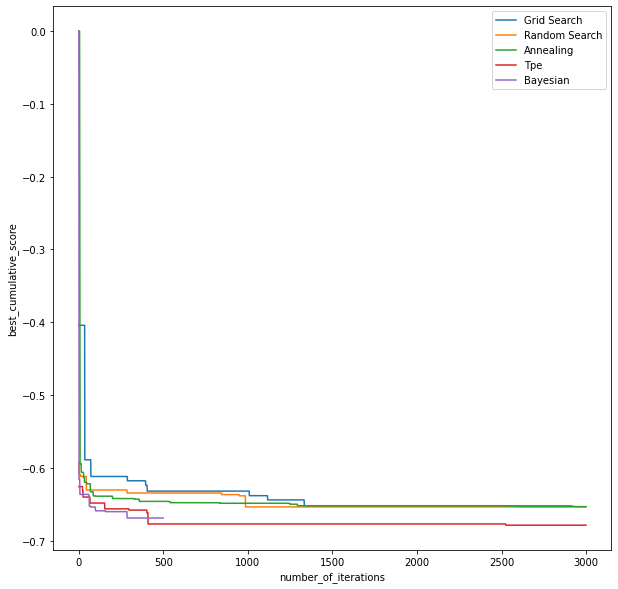

In [88]:
scores_df=pd.DataFrame(index=range(3000))
scores_df['Grid Search']=grid_search_results_df['score'].cummin()
scores_df['Random Search']=random_search_results_df['score'].cummin()
scores_df['Annealing']=anneal_results_df['score'].cummin()
scores_df['Tpe'] = tpe_results_df['score'].cummin()
scores_df['Bayesian'] = bayesian_results_df['score'].cummin()

ax = scores_df.plot(figsize=(10, 10))

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")